In [ ]:
import pandas as pd

# 读取第一个Excel文件
df1 = pd.read_excel('pearson_correlation_results.xlsx', engine='openpyxl')

# 删除包含缺失值的行
df1 = df1.dropna()

# 选择数值类型的列
numeric_cols = df1.select_dtypes(include=['number']).columns


numeric_cols = numeric_cols[25:]

# 计算每列第4到第9行（基于位置）的绝对值之和
abs_sum = df1.iloc[3:9, :][numeric_cols].abs().sum()


num_top = max(int(len(abs_sum) * 0.25), 1)
top_10_percent_columns = abs_sum.nlargest(num_top).index.tolist()

print("最大的10%的列的名称：", top_10_percent_columns)

# 选择年份和地区列
year_region_cols = ['年份', '地区']

# 构造最终需要的列列表
selected_cols = year_region_cols + top_10_percent_columns

# 读取第二个Excel文件
df3 = pd.read_excel('ct1.xlsx', engine='openpyxl')
df2 = pd.read_excel('ct2.xlsx', engine='openpyxl')

# 从第二个文件中选择指定的列
df_selected = df2[selected_cols].copy()

# 将专利数作为新列添加到 DataFrame 中
df_selected['高技术利润'] = df2['高技术产业_生产经营情况-高技术产业主要经济指标-利润总额_亿元']
# 检查每列的缺失值比例

# 保存到新的Excel文件
df_selected.to_excel('test.xlsx', index=False, engine='openpyxl')


最大的10%的列的名称： ['高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员-全时人员_信息化学品制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员-全时人员_医疗仪器设备及仪器仪表制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员-全时人员_医药制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员-全时人员_电子及通信设备制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员-全时人员_航空、航天器及设备制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员-全时人员_计算机及办公设备制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员-研究人员_信息化学品制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员-研究人员_医疗仪器设备及仪器仪表制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员-研究人员_医药制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员-研究人员_电子及通信设备制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员-研究人员_航空、航天器及设备制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员-研究人员_计算机及办公设备制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员_信息化学品制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员_医疗仪器设备及仪器仪表制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员_医药制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员_电子及通信设备制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员_航空、航天器及设备制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D人员_计算机及办公设备制造业_人', '高技术产业_R&D及相关活动情况-R&D活动人员-R&D活动人员折合全时当量_信息化学品制造业_人年', '高技术产业_R&D及相关活动情况-R&D活动人员-

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# 读取数据（之前保存的 test.xlsx）
df = pd.read_excel('test.xlsx', engine='openpyxl')

# 检查每列的缺失值比例
missing_threshold = 0.4
missing_ratio = df.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > missing_threshold].index
df = df.drop(columns=cols_to_drop)

# 将“地区”转换为整数编码
df['地区_code'] = df['地区'].astype('category').cat.codes

# 生成年份周期特征（假设年份为整数，例如 2000, 2001,...）
# 先将年份归一化，再生成 sin 和 cos 特征
df['年份_norm'] = (df['年份'] - df['年份'].min()) / (df['年份'].max() - df['年份'].min())
df['年份_sin'] = np.sin(2 * np.pi * df['年份_norm'])
df['年份_cos'] = np.cos(2 * np.pi * df['年份_norm'])

# 提取数值特征列
# 假设 test.xlsx 中除了 '年份', '地区', '高技术利润' 之外，其余为数值特征
numeric_cols = [col for col in df.columns if col not in ['年份', '地区', '地区_code', '年份_norm', '年份_sin', '年份_cos']]
# 如果数值特征为空，则构造一个虚拟特征（一般不会出现）
if len(numeric_cols) == 0:
    numeric_cols = ['dummy_feature']
    df['dummy_feature'] = 1.0

# 填充数值特征中的缺失值
df[numeric_cols] = df[numeric_cols].fillna(0)

# 标准化数值特征
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 按地区和年份排序（面板数据需要同一地区内的时间序列）
df = df.sort_values(by=['地区_code', '年份'])

# 构造面板数据序列
seq_len = 5
sequences = []
for region, group in df.groupby('地区_code'):
    group = group.sort_values(by='年份')
    if len(group) >= seq_len:
        # 滑动窗口：步长为1，每次取连续5年的数据
        for i in range(len(group) - seq_len + 1):
            seq = group.iloc[i:i+seq_len]
            sequences.append(seq)
print("Total sequences:", len(sequences))

Total sequences: 589


In [2]:
class PanelDataset(Dataset):
    def __init__(self, sequences, numeric_cols):
        self.sequences = sequences
        self.numeric_cols = numeric_cols
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        province = torch.tensor(seq['地区_code'].values[0], dtype=torch.long)
        year_features = torch.tensor(seq[['年份_sin', '年份_cos']].values, dtype=torch.float32)
        numeric_features = torch.tensor(seq[self.numeric_cols].values, dtype=torch.float32)
        target = torch.tensor(seq['高技术利润'].values[-1], dtype=torch.float32)
        return province, year_features, numeric_features, target

# 假设 adj 是一个静态的邻接矩阵
adj = torch.eye(32)  # 这里定义你的邻接矩阵，假设 batch_size 为 32

# 假设 sequences 已经生成，numeric_cols 已经定义
dataset = PanelDataset(sequences, numeric_cols)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)




In [3]:
# 定义 GRU-D Cell
class GRUDCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUDCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.gamma_x = nn.Parameter(torch.Tensor(input_size))
        self.gamma_h = nn.Parameter(torch.Tensor(hidden_size))
        
        self.W_r = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_z = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_h = nn.Linear(input_size + hidden_size, hidden_size)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.gamma_x, 0, 0.1)
        nn.init.uniform_(self.gamma_h, 0, 0.1)
    
    def forward(self, x, m, delta, h_prev):
        decay_x = torch.exp(-torch.relu(self.gamma_x * delta))
        x_hat = m * x + (1 - m) * (decay_x * x)
        delta_h = delta.mean(dim=1, keepdim=True)
        decay_h = torch.exp(-torch.relu(self.gamma_h * delta_h))
        h_prev = decay_h * h_prev
        
        combined = torch.cat([x_hat, h_prev], dim=1)
        r = torch.sigmoid(self.W_r(combined))
        z = torch.sigmoid(self.W_z(combined))
        combined_candidate = torch.cat([x_hat, r * h_prev], dim=1)
        h_tilde = torch.tanh(self.W_h(combined_candidate))
        h_new = (1 - z) * h_prev + z * h_tilde
        return h_new

# 定义 GCNLayer
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        support = self.linear(x)
        
        
        out = torch.mm(adj, support)
        return F.relu(out)

# 定义 PanelPredictionModel_GCN
class PanelPredictionModel_GCN(nn.Module):
    def __init__(self, num_provinces, province_emb_dim, input_size, hidden_size, gcn_hidden_size, num_classes=1):
        super(PanelPredictionModel_GCN, self).__init__()
        self.province_embedding = nn.Embedding(num_provinces, province_emb_dim)
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.gcn = GCNLayer(hidden_size + province_emb_dim, gcn_hidden_size)
        self.fc = nn.Linear(gcn_hidden_size, num_classes)
    
    def forward(self, province, year, numeric, adj):
        emb = self.province_embedding(province)
        x = torch.cat([year, numeric], dim=-1)
        _, h = self.gru(x)
        h = h.squeeze(0)
        combined = torch.cat([h, emb], dim=1)  # (batch_size, hidden_size + province_emb_dim)
        
        # 调整 adj 的形状以匹配 batch_size
        batch_size = combined.size(0)
        adj = adj[:batch_size, :batch_size]
        
        gcn_out = self.gcn(combined, adj)  # adj should be (batch_size, batch_size)
        out = self.fc(gcn_out)
        return out

# 假设 adj 是一个静态的邻接矩阵



In [4]:
for i, (province, year, numeric, target) in enumerate(train_loader):
    if i == 0:  # 只打印第一个批次的数据
        print(f"province: {province}")
        print(f"year: {year}")
        print(f"numeric: {numeric}")
        print(f"target: {target}")

    # 检查 NaN 和 Inf
    assert not torch.isnan(province).any(), "province contains NaN"
    assert not torch.isnan(year).any(), "year contains NaN"
    assert not torch.isnan(numeric).any(), "numeric contains NaN"
    assert not torch.isnan(target).any(), "target contains NaN"
    assert not torch.isinf(province).any(), "province contains Inf"
    assert not torch.isinf(year).any(), "year contains Inf"
    assert not torch.isinf(numeric).any(), "numeric contains Inf"
    assert not torch.isinf(target).any(), "target contains Inf"



province: tensor([ 5, 26, 27, 21,  4, 14,  1, 17, 17, 24,  5,  8, 28, 13, 16,  6,  6, 17,
         8, 29, 25,  5, 17, 28,  4,  1, 17,  2,  0,  5,  7, 15])
year: tensor([[[ 9.0963e-01, -4.1542e-01],
         [ 7.5575e-01, -6.5486e-01],
         [ 5.4064e-01, -8.4125e-01],
         [ 2.8173e-01, -9.5949e-01],
         [ 1.2246e-16, -1.0000e+00]],

        [[ 1.2246e-16, -1.0000e+00],
         [-2.8173e-01, -9.5949e-01],
         [-5.4064e-01, -8.4125e-01],
         [-7.5575e-01, -6.5486e-01],
         [-9.0963e-01, -4.1542e-01]],

        [[ 2.8173e-01,  9.5949e-01],
         [ 5.4064e-01,  8.4125e-01],
         [ 7.5575e-01,  6.5486e-01],
         [ 9.0963e-01,  4.1542e-01],
         [ 9.8982e-01,  1.4231e-01]],

        [[-5.4064e-01, -8.4125e-01],
         [-7.5575e-01, -6.5486e-01],
         [-9.0963e-01, -4.1542e-01],
         [-9.8982e-01, -1.4231e-01],
         [-9.8982e-01,  1.4231e-01]],

        [[ 9.8982e-01,  1.4231e-01],
         [ 9.8982e-01, -1.4231e-01],
         [ 9.0963

In [21]:
class PanelDataset(Dataset):
    def __init__(self, sequences, numeric_cols):
        self.sequences = sequences
        self.numeric_cols = numeric_cols
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        province = torch.tensor(seq['地区_code'].values[0], dtype=torch.long)
        year_features = torch.tensor(seq[['年份_sin', '年份_cos']].values, dtype=torch.float32)
        numeric_features = torch.tensor(seq[self.numeric_cols].values, dtype=torch.float32)
        target = torch.tensor(seq['高技术利润'].values[-1], dtype=torch.float32)
        return province, year_features, numeric_features, target

# 假设 adj 是一个静态的邻接矩阵
adj = torch.eye(32)  # 这里定义你的邻接矩阵，假设 batch_size 为 32

# 假设 sequences 已经生成，numeric_cols 已经定义
dataset = PanelDataset(sequences, numeric_cols)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)


# 定义模型
class PanelPredictionModel_GCN(nn.Module):
    def __init__(self, num_provinces, province_emb_dim, input_size, hidden_size, gcn_hidden_size, num_classes=1):
        super(PanelPredictionModel_GCN, self).__init__()
        self.province_embedding = nn.Embedding(num_provinces, province_emb_dim)
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.gcn = GCNLayer(hidden_size + province_emb_dim, gcn_hidden_size)
        self.fc = nn.Linear(gcn_hidden_size, num_classes)
    
    def forward(self, province, year, numeric, adj):
        emb = self.province_embedding(province)
        x = torch.cat([year, numeric], dim=-1)
        _, h = self.gru(x)
        h = h.squeeze(0)
        combined = torch.cat([h, emb], dim=1)  # (batch_size, hidden_size + province_emb_dim)
        
        # 调整 adj 的形状以匹配 batch_size
        batch_size = combined.size(0)
        adj = adj[:batch_size, :batch_size]
        
        gcn_out = self.gcn(combined, adj)  # adj should be (batch_size, batch_size)
        out = self.fc(gcn_out)
        return out

model = PanelPredictionModel_GCN(num_provinces=len(df['地区_code'].unique()), 
                                 province_emb_dim=16, 
                                 input_size=len(numeric_cols) + 2, 
                                 hidden_size=32, 
                                 gcn_hidden_size=32)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)
train_losses = []
val_losses = []
num_epochs = 10



In [6]:
adj

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [7]:
import torch.nn.functional as F

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for province, year, numeric, target in train_loader:
        optimizer.zero_grad()
        pred = model(province, year, numeric, adj)
        loss = criterion(pred.squeeze(), target)
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Found NaN or Inf in loss at epoch {epoch}, skipping this batch")
            continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 添加梯度裁剪
        optimizer.step()
        train_loss += loss.item() * province.size(0)
    train_loss /= len(train_loader.dataset)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for province, year, numeric, target in val_loader:
            pred = model(province, year, numeric, adj)
            loss = criterion(pred.squeeze(), target)
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Found NaN or Inf in loss at epoch {epoch}, skipping this batch")
                continue
            val_loss += loss.item() * province.size(0)
    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/10, Train Loss: 0.5437, Val Loss: 0.0986
Epoch 2/10, Train Loss: 0.2352, Val Loss: 0.0387
Epoch 3/10, Train Loss: 0.0936, Val Loss: 0.0461
Epoch 4/10, Train Loss: 0.0461, Val Loss: 0.0843
Epoch 5/10, Train Loss: 0.0547, Val Loss: 0.0596
Epoch 6/10, Train Loss: 0.0439, Val Loss: 0.0434
Epoch 7/10, Train Loss: 0.0316, Val Loss: 0.0290
Epoch 8/10, Train Loss: 0.0573, Val Loss: 0.0471
Epoch 9/10, Train Loss: 0.0462, Val Loss: 0.0433
Epoch 10/10, Train Loss: 0.0395, Val Loss: 0.0679


Epoch 1/50, Train Loss: 0.9710, Val Loss: 0.7088
Epoch 2/50, Train Loss: 0.6302, Val Loss: 0.4662
Epoch 3/50, Train Loss: 0.4547, Val Loss: 0.3172
Epoch 4/50, Train Loss: 0.3469, Val Loss: 0.2548
Epoch 5/50, Train Loss: 0.2734, Val Loss: 0.1674
Epoch 6/50, Train Loss: 0.2067, Val Loss: 0.1146
Epoch 7/50, Train Loss: 0.1588, Val Loss: 0.0747
Epoch 8/50, Train Loss: 0.1252, Val Loss: 0.0479
Epoch 9/50, Train Loss: 0.0998, Val Loss: 0.0342
Epoch 10/50, Train Loss: 0.0831, Val Loss: 0.0374
Epoch 11/50, Train Loss: 0.0648, Val Loss: 0.0336
Epoch 12/50, Train Loss: 0.0561, Val Loss: 0.0355
Epoch 13/50, Train Loss: 0.0489, Val Loss: 0.0388
Epoch 14/50, Train Loss: 0.0451, Val Loss: 0.0374
Epoch 15/50, Train Loss: 0.0380, Val Loss: 0.0338
Epoch 16/50, Train Loss: 0.0330, Val Loss: 0.0351
Epoch 17/50, Train Loss: 0.0308, Val Loss: 0.0315
Epoch 18/50, Train Loss: 0.0247, Val Loss: 0.0338
Epoch 19/50, Train Loss: 0.0218, Val Loss: 0.0315
Epoch 20/50, Train Loss: 0.0184, Val Loss: 0.0342
Epoch 21/

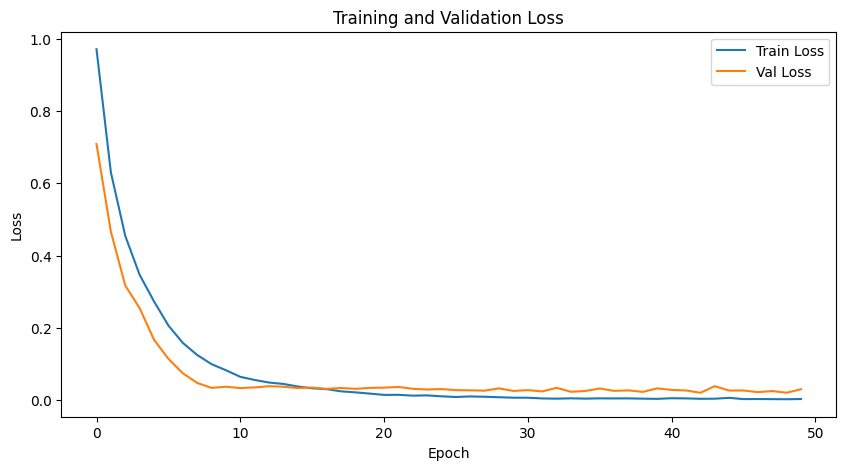

In [8]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
train_losses = []
val_losses = []
model = PanelPredictionModel_GCN(num_provinces=len(df['地区_code'].unique()), 
                                 province_emb_dim=16, 
                                 input_size=len(numeric_cols) + 2, 
                                 hidden_size=32, 
                                 gcn_hidden_size=32)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)
train_losses = []
val_losses = []
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters())  # 重新定义优化器
# 训练循环
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for province, year, numeric, target in train_loader:
        optimizer.zero_grad()
        pred = model(province, year, numeric, adj)
        loss = criterion(pred.squeeze(), target)
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Found NaN or Inf in loss at epoch {epoch}, skipping this batch")
            continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 添加梯度裁剪
        optimizer.step()
        train_loss += loss.item() * province.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for province, year, numeric, target in val_loader:
            pred = model(province, year, numeric,  adj)
            loss = criterion(pred.squeeze(), target)
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Found NaN or Inf in loss at epoch {epoch}, skipping this batch")
                continue
            val_loss += loss.item() * province.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# 绘制训练和验证损失曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()